In [25]:
import os, glob
import mne
import numpy as np
import pickle
import matplotlib.pyplot as plt
import librosa
import soundfile as sf

os.chdir("/home/jerryjin/moth-meg-dataset")
from src.correct_delay_funcs import *

### Set Parameters

First, we specify which session and subject we will be considering for analysis.

In [26]:
SUBJECT = "D"
SESSION = "Moth5"
BLOCKS = ["01", "02", "03", "04", "05", "06", "07", "08"] if SESSION == "Moth1" or SESSION == "Moth4" else ["01", "02", "03", "04", "05", "06", "07"]
LOC_AUDIO = "/project_data/volume0/lwehbe/ds003020/stimuli/"
LOC_RAW = f"/project_data/volume0/jerryjin/moth_meg/{SESSION}/raw/{SUBJECT}/"
LOC_SAVE = f"/project_data/volume0/jerryjin/moth_meg/{SESSION}/delay_correction/"
SAVE_ACOUSTIC = False

Next, we will define some general objects. The story order is specified during the experimental setup. It is important to keep a log file for every single session (time where a subject goes to the scanner) that indicates exactly which stories were played. Note that for Moth1, block 1 is the audio localizer. We might not want to include that in other formal analysis.

In [27]:
# Or you could load them from the saved files
# stories in each session, in order
with open("support_data/session_stories_dict.pkl", "rb") as f:
    session_stories_dict = pickle.load(f)
print(session_stories_dict)

# story to session and block mapping
with open("support_data/story_sess_block.pkl", "rb") as f:
    story_sess_block = pickle.load(f)
print(story_sess_block)

# story to unique story mapping
with open("support_data/story_to_uniquestory.pkl", "rb") as f:
    story_to_uniquestory = pickle.load(f)
print(story_to_uniquestory)

# the value in the stim channel that corresponds to the audio
with open("support_data/stim_on_val.pkl", "rb") as f:
    STIM_ON_VAL = pickle.load(f)
print(STIM_ON_VAL)

{'Moth1': ['stimuli_auditory_localizer', 'alternateithicatom1', 'souls', 'wheretheressmoke1', 'avatar', 'legacy', 'odetostepfather', 'alternateithicatom2'], 'Moth2': ['undertheinfluence1', 'howtodraw', 'myfirstdaywiththeyankees', 'wheretheressmoke2', 'naked', 'life', 'undertheinfluence2'], 'Moth3': ['stagefright1', 'tildeath', 'wheretheressmoke3', 'fromboyhoodtofatherhood', 'sloth', 'exorcism', 'stagefright2'], 'Moth4': ['buck1', 'adollshouse', 'wheretheressmoke4', 'inamoment', 'theclosetthatateeverything', 'adventuresinsayingyes', 'haveyoumethimyet', 'buck2'], 'Moth5': ['swimmingwithastronauts1', 'thatthingonmyarm', 'eyespy', 'wheretheressmoke5', 'itsabox', 'hangtime', 'swimmingwithastronauts2']}
{'stimuli_auditory_localizer': ('Moth1', '01'), 'alternateithicatom1': ('Moth1', '02'), 'souls': ('Moth1', '03'), 'wheretheressmoke1': ('Moth1', '04'), 'avatar': ('Moth1', '05'), 'legacy': ('Moth1', '06'), 'odetostepfather': ('Moth1', '07'), 'alternateithicatom2': ('Moth1', '08'), 'underthein

In [28]:
# stimulus channel name and audio channel name, these need to be double checked each time
STIM_CH = "STI101"
AUDIO_CH = "MISC008"

In [29]:
# the stories of this session
story_list = session_stories_dict[SESSION]
story_list

['swimmingwithastronauts1',
 'thatthingonmyarm',
 'eyespy',
 'wheretheressmoke5',
 'itsabox',
 'hangtime',
 'swimmingwithastronauts2']

### Run Correction

The process first involves finding the initial lag amount and the final lag amount using the `determine_lag` function. Next, we can calculate the rate of update by computing $\text{rate} = \frac{\text{final story lags[story]} - \text{initial lags[story]}}{\text{len(audio signal)}_\text{pre-0-pad}}$. We can then fix the initial lag and also stretch the signal by resampling at a lower sampling rate found by $f_{s, \text{stretch}} = f_s \cdot \text{rate}$. We iterate this process for more times to increase accuracy. Finally, we can zero-pad this signal at the start given the initial lags.

swimmingwithastronauts1


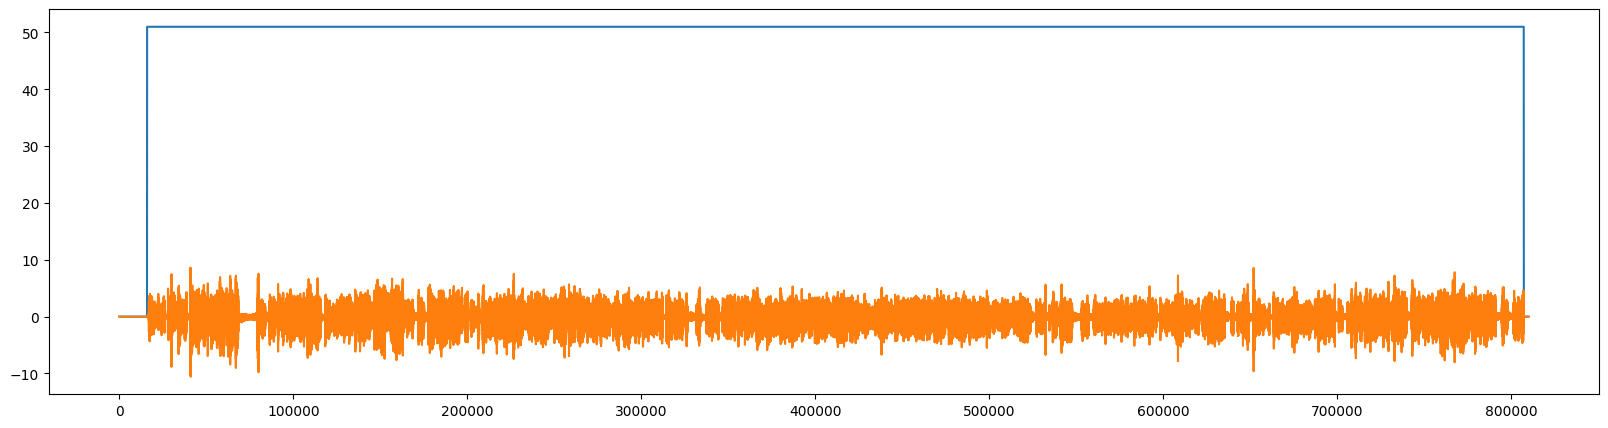

Computing initial lag for swimmingwithastronauts1: 492 ms
Computing final story lag for swimmingwithastronauts1: 868 ms
Rate for swimmingwithastronauts1: 1.000475203478085

Computing initial lag for swimmingwithastronauts1: -1 ms
swimmingwithastronauts1 start_samp_meg + duration_samp is out of range of meg audio length, shortening to the end of the meg audio
Computing final story lag for swimmingwithastronauts1: 9 ms
Rate for swimmingwithastronauts1: 1.0000126245410978

Computing initial lag for swimmingwithastronauts1: 0 ms
swimmingwithastronauts1 start_samp_meg + duration_samp is out of range of meg audio length, shortening to the end of the meg audio
Computing final story lag for swimmingwithastronauts1: 0 ms
Rate for swimmingwithastronauts1: 1.0

{'meg_sr': 1000, 'initial_lag': 491.00621127422016, 'initial_lag_time': 0.4910062112742202, 'rate': 1.0004878340184087, 'meg_acoustic_diff': -728, 'meg_acoustic_diff_time': -0.728}
Saving corrected acoustic data (1k Hz) to /project_data/vo

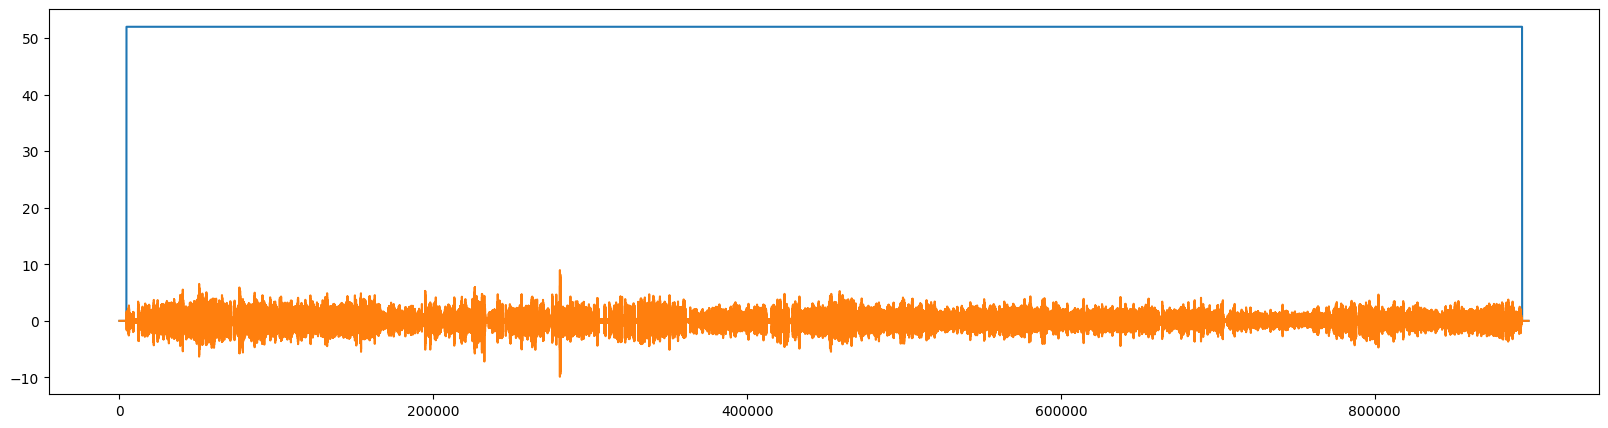

Computing initial lag for thatthingonmyarm: 29 ms
Computing final story lag for thatthingonmyarm: 455 ms
Rate for thatthingonmyarm: 1.0004793092546067

Computing initial lag for thatthingonmyarm: 0 ms
Computing final story lag for thatthingonmyarm: 8 ms
Rate for thatthingonmyarm: 1.000008996496989

Computing initial lag for thatthingonmyarm: 0 ms
Computing final story lag for thatthingonmyarm: 0 ms
Rate for thatthingonmyarm: 1.0

{'meg_sr': 1000, 'initial_lag': 29.00026089841268, 'initial_lag_time': 0.02900026089841268, 'rate': 1.0004883100636999, 'meg_acoustic_diff': 195, 'meg_acoustic_diff_time': 0.195}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth5/delay_correction/corrected_acoustic_data/D/thatthingonmyarm.pkl
Saving delay correction coefficients to /project_data/volume0/jerryjin/moth_meg/Moth5/delay_correction/coefficients/D/thatthingonmyarm.pkl
eyespy


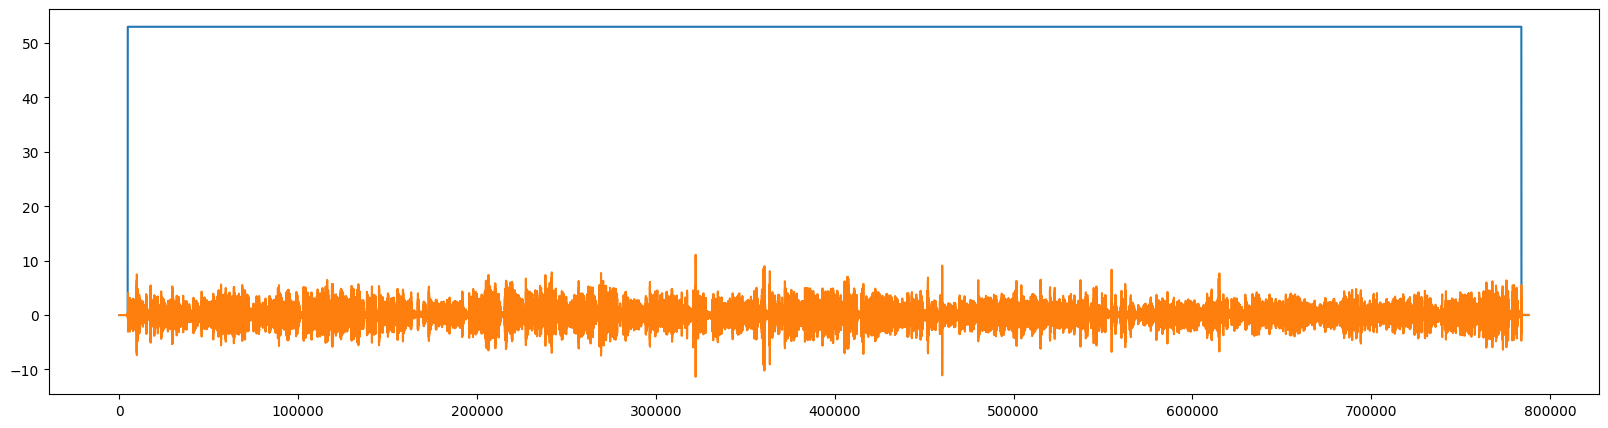

Computing initial lag for eyespy: 30 ms
Computing final story lag for eyespy: 403 ms
Rate for eyespy: 1.000478552385449

Computing initial lag for eyespy: -1 ms
Computing final story lag for eyespy: 7 ms
Rate for eyespy: 1.0000102585540311

Computing initial lag for eyespy: 0 ms
Computing final story lag for eyespy: 0 ms
Rate for eyespy: 1.0

{'meg_sr': 1000, 'initial_lag': 29.000307756620934, 'initial_lag_time': 0.029000307756620936, 'rate': 1.0004888158487355, 'meg_acoustic_diff': -459, 'meg_acoustic_diff_time': -0.459}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth5/delay_correction/corrected_acoustic_data/D/eyespy.pkl
Saving delay correction coefficients to /project_data/volume0/jerryjin/moth_meg/Moth5/delay_correction/coefficients/D/eyespy.pkl
wheretheressmoke5


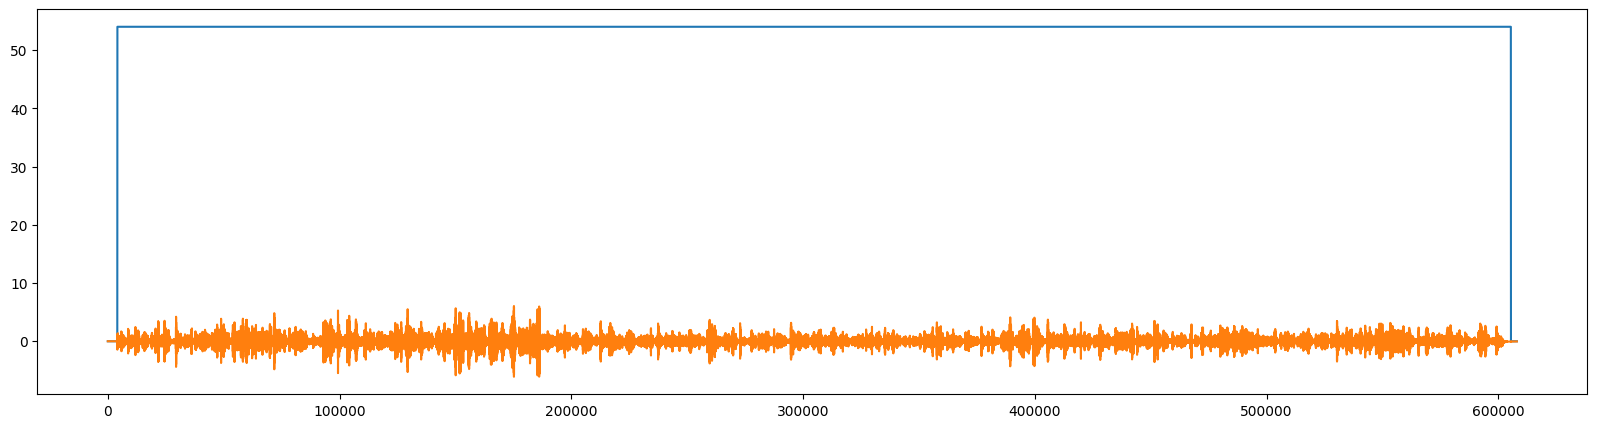

Computing initial lag for wheretheressmoke5: 30 ms
Computing final story lag for wheretheressmoke5: 318 ms
Rate for wheretheressmoke5: 1.0004784537968132

Computing initial lag for wheretheressmoke5: -1 ms
wheretheressmoke5 start_samp_meg + duration_samp is out of range of meg audio length, shortening to the end of the meg audio
Computing final story lag for wheretheressmoke5: 5 ms
Rate for wheretheressmoke5: 1.0000099625243044

Computing initial lag for wheretheressmoke5: 0 ms
wheretheressmoke5 start_samp_meg + duration_samp is out of range of meg audio length, shortening to the end of the meg audio
Computing final story lag for wheretheressmoke5: 0 ms
Rate for wheretheressmoke5: 1.0

{'meg_sr': 1000, 'initial_lag': 29.000298875729133, 'initial_lag_time': 0.029000298875729132, 'rate': 1.0004884210877252, 'meg_acoustic_diff': -965, 'meg_acoustic_diff_time': -0.965}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth5/delay_correction/corrected_acousti

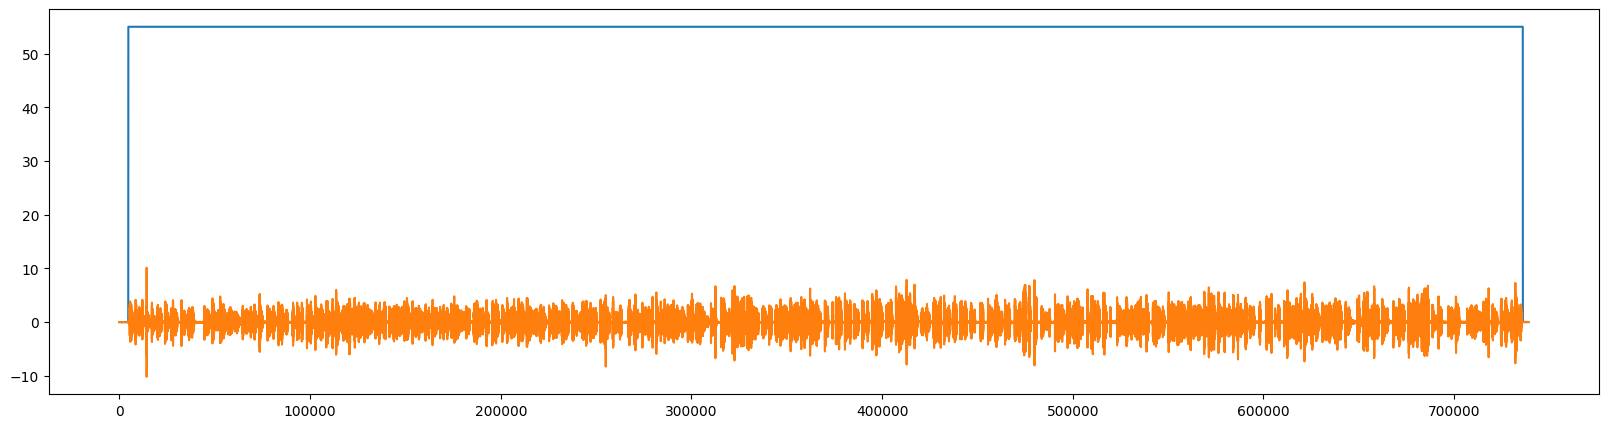

Computing initial lag for itsabox: 29 ms
Computing final story lag for itsabox: 380 ms
Rate for itsabox: 1.000480338946867

Computing initial lag for itsabox: 0 ms
Computing final story lag for itsabox: 6 ms
Rate for itsabox: 1.0000082066545026

Computing initial lag for itsabox: -1 ms
Computing final story lag for itsabox: 0 ms
Rate for itsabox: 1.0000013677645256

Computing initial lag for itsabox: 0 ms
Computing final story lag for itsabox: 0 ms
Rate for itsabox: 1.0

{'meg_sr': 1000, 'initial_lag': 28.000277658477337, 'initial_lag_time': 0.028000277658477336, 'rate': 1.000489917976092, 'meg_acoustic_diff': 240, 'meg_acoustic_diff_time': 0.24}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth5/delay_correction/corrected_acoustic_data/D/itsabox.pkl
Saving delay correction coefficients to /project_data/volume0/jerryjin/moth_meg/Moth5/delay_correction/coefficients/D/itsabox.pkl
hangtime


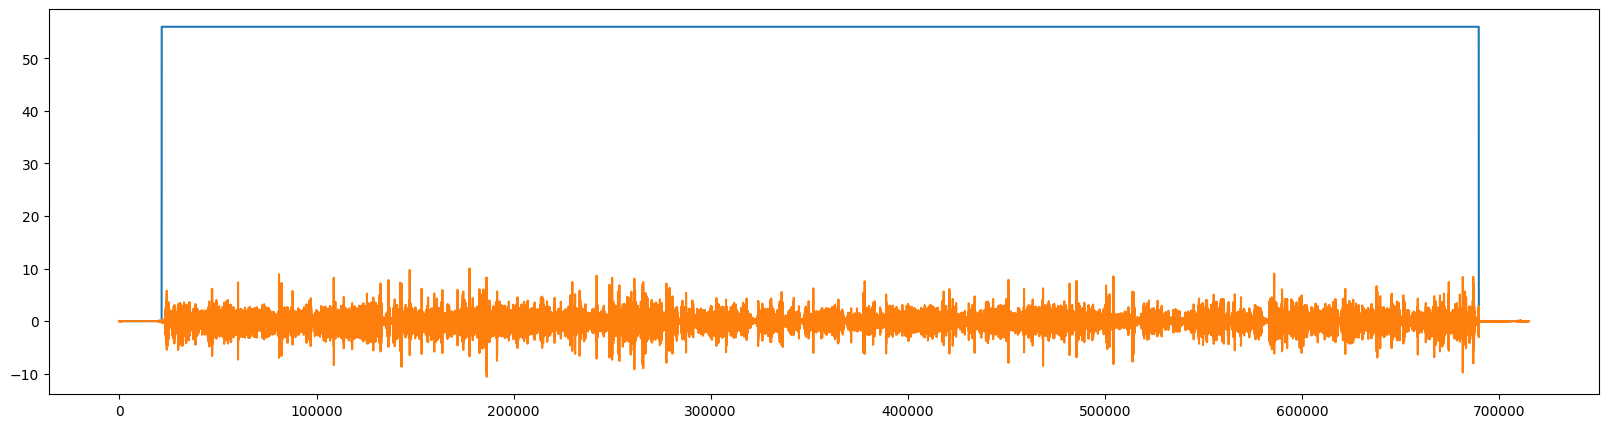

Computing initial lag for hangtime: 30 ms
Computing final story lag for hangtime: 353 ms
Rate for hangtime: 1.0004832985198795

Computing initial lag for hangtime: -2 ms
Computing final story lag for hangtime: 2 ms
Rate for hangtime: 1.0000059819613953

Computing initial lag for hangtime: 0 ms
Computing final story lag for hangtime: 0 ms
Rate for hangtime: 1.0

{'meg_sr': 1000, 'initial_lag': 28.00017945884186, 'initial_lag_time': 0.02800017945884186, 'rate': 1.000489283372348, 'meg_acoustic_diff': -350, 'meg_acoustic_diff_time': -0.35}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth5/delay_correction/corrected_acoustic_data/D/hangtime.pkl
Saving delay correction coefficients to /project_data/volume0/jerryjin/moth_meg/Moth5/delay_correction/coefficients/D/hangtime.pkl
swimmingwithastronauts2


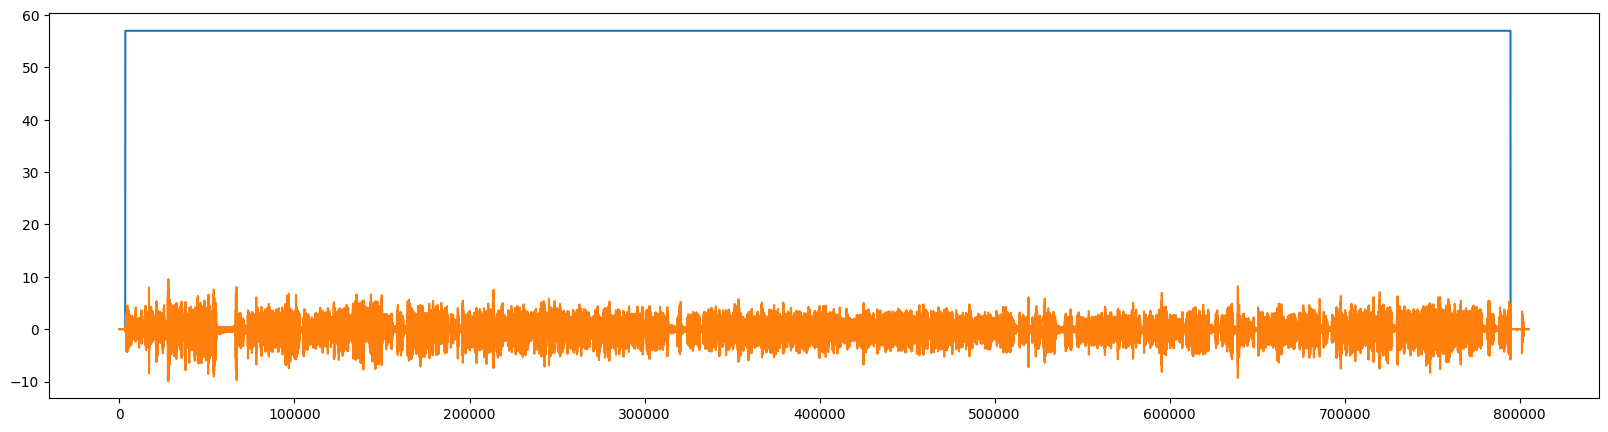

Computing initial lag for swimmingwithastronauts2: 30 ms
Computing final story lag for swimmingwithastronauts2: 407 ms
Rate for swimmingwithastronauts2: 1.0004764673171225

Computing initial lag for swimmingwithastronauts2: 0 ms
Computing final story lag for swimmingwithastronauts2: 9 ms
Rate for swimmingwithastronauts2: 1.000011368703475

Computing initial lag for swimmingwithastronauts2: 0 ms
Computing final story lag for swimmingwithastronauts2: 0 ms
Rate for swimmingwithastronauts2: 1.0

{'meg_sr': 1000, 'initial_lag': 30.00034106110425, 'initial_lag_time': 0.03000034106110425, 'rate': 1.0004878414374132, 'meg_acoustic_diff': -266, 'meg_acoustic_diff_time': -0.266}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth5/delay_correction/corrected_acoustic_data/D/swimmingwithastronauts2.pkl
Saving delay correction coefficients to /project_data/volume0/jerryjin/moth_meg/Moth5/delay_correction/coefficients/D/swimmingwithastronauts2.pkl


In [30]:
for BLOCK in BLOCKS:

    # get the story name
    record_id = int(BLOCK[-1])
    this_story = story_list[record_id - 1]
    this_story_unique = story_to_uniquestory[this_story]
    print(this_story)

    # load the raw file
    raw_file = glob.glob(LOC_RAW + f"*{SUBJECT}_{SESSION}_{BLOCK}*.fif")[0]
    raw = mne.io.read_raw_fif(raw_file, verbose=False)
    meg_sr = int(raw.info["sfreq"])

    # get stim channel data
    stim_ch_data = raw.copy().pick([STIM_CH]).get_data()[0]

    # get audio channel data
    audio_ch_data = raw.copy().pick([AUDIO_CH]).get_data()[0]

    # load the acoustic file (wav) of this story
    acoustic_file = LOC_AUDIO + f"{this_story_unique}.wav"
    acoustic_data = librosa.load(acoustic_file, sr=meg_sr)[0]

    # plot to check if the stim channel and audio channel are roughly aligned
    plt.subplots(figsize=(20, 5))
    plt.plot(stim_ch_data)
    plt.plot(audio_ch_data)
    plt.show()

    # compute initial lags and stretch rates
    initial_lag, rate = compute_meg_acoustic_diff(
        story=this_story,
        acoustic_data=acoustic_data,
        audio_ch_data=audio_ch_data,
        fs=meg_sr,
        stim_ch_data=stim_ch_data,
        STIM_ON_VAL=STIM_ON_VAL,
        initial_duration=3,  # be cautious with this
        final_duration=20,
    )

    # stretch the original audio to algin with MEG audio
    corrected_acoustic_data = stretch_shift_acoustic(
        acoustic_data=acoustic_data,
        fs=meg_sr,
        initial_lag=initial_lag,
        rate=rate,
    )

    # do this process iteratively so that it is more precise
    for _ in range(10):
        initial_lag_tmp, rate_tmp = compute_meg_acoustic_diff(
            story=this_story,
            acoustic_data=corrected_acoustic_data,
            audio_ch_data=audio_ch_data,
            fs=meg_sr,
            stim_ch_data=stim_ch_data,
            STIM_ON_VAL=STIM_ON_VAL,
            initial_duration=10,
            final_duration=20,
        )

        if rate_tmp == 1:
            break

        corrected_acoustic_data = stretch_shift_acoustic(
            acoustic_data=corrected_acoustic_data,
            fs=meg_sr,
            initial_lag=initial_lag_tmp,
            rate=rate_tmp,
        )

        rate *= rate_tmp
        initial_lag = initial_lag * rate_tmp + initial_lag_tmp

    # calculate meg_acoustic_diff and correct the final lags
    num_acoustic_samples = len(corrected_acoustic_data)
    num_meg_audio_samples = np.sum(stim_ch_data == STIM_ON_VAL[this_story])
    meg_acoustic_diff = num_meg_audio_samples - num_acoustic_samples
    corrected_acoustic_data = align_meg_acoustic_end(corrected_acoustic_data, meg_acoustic_diff)
    assert audio_ch_data[stim_ch_data == STIM_ON_VAL[this_story]].shape == corrected_acoustic_data.shape
    assert initial_lag >= 0

    # The delay correlation coefficients (important for later analysis)
    delay_correction_coefs = {
        "meg_sr": meg_sr,
        "initial_lag": initial_lag,
        "initial_lag_time": initial_lag / meg_sr,
        "rate": rate,
        "meg_acoustic_diff": meg_acoustic_diff,
        "meg_acoustic_diff_time": meg_acoustic_diff / meg_sr,
    }
    print(delay_correction_coefs)

    # save the strethced acoustic data (1k Hz)
    corrected_acoustic_folder = LOC_SAVE + f"corrected_acoustic_data/{SUBJECT}"
    # if the directory does not exist, create it
    if not os.path.exists(corrected_acoustic_folder):
        os.makedirs(corrected_acoustic_folder)
    corrected_acoustic_path = f"{corrected_acoustic_folder}/{this_story}.pkl"
    print(f"Saving corrected acoustic data (1k Hz) to {corrected_acoustic_path}")
    with open(corrected_acoustic_path, "wb") as f:
        pickle.dump(corrected_acoustic_data, f)

    # save the coefficients of delay correction
    delay_correction_folder = LOC_SAVE + f"coefficients/{SUBJECT}"
    # if the directory does not exist, create it
    if not os.path.exists(delay_correction_folder):
        os.makedirs(delay_correction_folder)
    delay_correction_path = f"{delay_correction_folder}/{this_story}.pkl"
    print(f"Saving delay correction coefficients to {delay_correction_path}")
    with open(delay_correction_path, "wb") as f:
        pickle.dump(delay_correction_coefs, f)

    if SAVE_ACOUSTIC:
        # load the original acoustic data in 40k Hz
        highfs = 40000
        acoustic_data_highfs = librosa.load(acoustic_file, sr=highfs)[0]

        # correct the highfs acoustic data
        corrected_acoustic_data_highfs = stretch_shift_acoustic(
            acoustic_data=acoustic_data_highfs,
            fs=highfs,
            initial_lag=initial_lag,
            rate=rate,
        )
        scale_factor = highfs / meg_sr
        meg_acoustic_diff_highfs = int(num_meg_audio_samples * scale_factor - len(corrected_acoustic_data_highfs))
        corrected_acoustic_data_highfs = align_meg_acoustic_end(corrected_acoustic_data_highfs, meg_acoustic_diff_highfs)

        # folder to save the strethced acoustic data (40k Hz)
        wav_folder_40k = LOC_SAVE + f"wav_files_40k/{SUBJECT}"
        # if the directory does not exist, create it
        if not os.path.exists(wav_folder_40k):
            os.makedirs(wav_folder_40k)
        print(f"Saving aligned audio files to {wav_folder_40k}/{this_story}.wav")
        sf.write(f"{wav_folder_40k}/{this_story}.wav", corrected_acoustic_data_highfs, 40000)

        # verify the corrected 40k wav file
        test_corrected_acoustic_data = librosa.load(f"{wav_folder_40k}/{this_story}.wav", sr=meg_sr)[0]  # downsample to 1k Hz
        _ = determine_lag(
            story=this_story,
            acoustic_data=test_corrected_acoustic_data,
            fs=meg_sr,
            audio_ch_data=audio_ch_data[stim_ch_data == STIM_ON_VAL[this_story]],
            start=500,
            duration=40,
            plot=True,
        )